In [30]:

    
import itertools
import pprint
import argparse
import sys
import os
import pylab as plt
import pandas as pd
import sys
import numpy as np
import hashlib 
import pickle
import json
import glob
import copy
from itertools import groupby
from importlib import reload
savedir_base = '/mnt/datasets/public/issam/prototypes/sls/borgy/'
haven_borgy = '/home/issam/Research_Ground/haven_borgy'
sys.path.append(haven_borgy)
# sys.path.append(workdir)

from haven import haven_jupyter as hj
from haven import haven_results as hr
from haven import haven_dropbox as hd
from haven import haven_utils as hu

hj.init_datatable_mode()
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


<IPython.core.display.Javascript object>

In [54]:
!{sys.executable} -m pip install --upgrade  '/home/issam/Research_Ground/haven/' --user

reload(hj)
reload(hr)
reload(hd)
reload(hu)


Processing /home/issam/Research_Ground/haven
  Created wheel for haven: filename=haven-0.1-cp37-none-any.whl size=22048 sha256=22b57a04a7eb16706353d6eac868885d51ac21f11e289033b717b1e61fabeee9
  Stored in directory: /tmp/pip-ephem-wheel-cache-7hmtzpdu/wheels/a7/ce/67/5d7012be13e42989ac0566940e2528ab36067bfedbe3a8b8cb
Successfully built haven
  Found existing installation: haven 0.1
    Uninstalling haven-0.1:
      Successfully uninstalled haven-0.1


<module 'haven.haven_utils' from '/mnt/home/issam/.local/lib/python3.7/site-packages/haven/haven_utils.py'>

In [4]:
# EXP CONFIG
from haven import haven_utils as hu
import itertools 

EXP_GROUPS = {}
syn_datasets = ["synthetic"]
syn_dims = [20]
margin_list = [0.1, 0.01, 0.05,  0.5]

kernel_datasets = ["mushrooms","w8a",   "ijcnn", "rcv1"]
c_list = [0.15, 1.0, 0.2, 0.25, 0.35, 0.1, 0.5,0.05]
# c_list = [0.15]
splr_list = []
for c, eta_max in itertools.product(c_list, [100, 10,  1000]):
        splr_list += [{'name':"splr", "c":c, 'adapt_flag':'constant', 'eta_max':eta_max}]

for c, adapt_flag in itertools.product(c_list, ['smooth_iter']):
        splr_list += [{'name':"splr", 
        "c":c, 'adapt_flag':adapt_flag}]

sgd_armijo_list = []
for c, gamma in itertools.product([0.1, 0.5],
                                  [1.5]):
        sgd_armijo_list += [{"name": "sgd_armijo", 
                             "gamma":gamma, "c":c}]
# sgd_armijo_list = []
run_list = [0, 1, 2, 3, 4]


others_list = [{'name':'adam'}, 
               {'name':'radam'},
                {'name':'lookahead'},
                {'name':'ali_g', 'momentum':0},
                {'name':'ali_g', 'momentum':0., 'max_lr':0.1}
                                ]

# alig_opt_list = [{"name":"ali_g", "momentum":0}, # without max lr (ali-g infinity)
#                  {"name":"ali_g", "momentum":0.9},
#                  {"name":"ali_g", "momentum":0, "max_lr": 0.1}, # with max lr
#                  {"name":"ali_g", "momentum":0.9, "max_lr": 0.1}]
opt_list =  splr_list + sgd_armijo_list +others_list
# 
EXP_GROUPS['splr_kernel'] = hu.cartesian_exp_group({"dataset":kernel_datasets,
                                "model":["linear"],
                                "loss_func": ['logistic_loss'],
                                "acc_func": ["logistic_accuracy"],
                                "opt": opt_list ,
                                "batch_size":[100],
                                "max_epoch":[35],
                                "runs":run_list})

# EXP_GROUPS['splr_syn_inter'] = (hu.cartesian_exp_group({"dataset":syn_datasets,
#                 "model":["logistic"],
#                 "loss_func": ["logistic_loss"],
#                 "acc_func": ["logistic_accuracy"],
#                 "n_samples": [1000],
#                 "d": syn_dims,
#                 "opt": splr_list+ sgd_armijo_list+ others_list,
#                 "margin":margin_list,
#                 "separable":[True],
#                 "batch_size":[100],
#                 "max_epoch":[200],
#                 "runs":run_list}))

EXP_GROUPS['splr_mf'] = hu.cartesian_exp_group({"dataset":["matrix_fac"],
                                "model":["matrix_fac_1", "matrix_fac_4", "matrix_fac_10", "linear_fac"],
                                "loss_func": ["squared_loss"],
                                "opt": opt_list,
                                "acc_func":["mse"],
                                "batch_size":[100],
                                "max_epoch":[50],
                                "runs":run_list})

EXP_GROUPS['splr_mnist'] = hu.cartesian_exp_group({"dataset":["mnist"],
                                "model":["mlp"],
                                "loss_func": ["softmax_loss"],
                                "opt": opt_list,
                                "acc_func":["softmax_accuracy"],
                                "batch_size":[128],
                                "max_epoch":[200],
                                "runs":run_list})

EXP_GROUPS['splr_deep'] = (hu.cartesian_exp_group({"dataset":["cifar10"],
                                "model":["resnet34", "densenet121"],
                                "loss_func": ["softmax_loss"],
                                "opt": opt_list,
                                "acc_func":["softmax_accuracy"],
                                "batch_size":[128],
                                "max_epoch":[200],
                                "runs":run_list}) +

                        hu.cartesian_exp_group({"dataset":["cifar100"],
                                        "model":["resnet34_100", "densenet121_100"],
                                        "loss_func": ["softmax_loss"],
                                        "opt": opt_list,
                                        "acc_func":["softmax_accuracy"],
                                        "batch_size":[128],
                                        "max_epoch":[200],
                                        "runs":run_list})
                                )
splr_inter = []
for k in EXP_GROUPS.keys():
    splr_inter += EXP_GROUPS[k]
EXP_GROUPS['splr_inter'] = splr_inter


# get exp list
exp_list = []
for exp_group_name in ['splr_inter']:
    exp_list += EXP_GROUPS[exp_group_name]


In [55]:


kernel_datasets = [{'dataset':d} for d in ["mushrooms", "ijcnn"]]
mf_datasets = [{'dataset':'matrix_fac', 'model':m} for m in ["matrix_fac_4", "matrix_fac_10"]]
# # syn_datasets = [{'dataset':'synthetic', 'margin':m} for m in [0.1, 0.01, 0.05,  0.5]]

# exp_list = hr.filter_exp_list(exp_list, 
#                             regard_dict=kernel_datasets +  mf_datasets,
#                             disregard_dict=None) 
# print(kernel_datasets)
# stop
rm = hr.ResultManager(exp_list, savedir_base,
                      regard_dict_list=[
                                (kernel_datasets +  mf_datasets),
                                [
                                {'opt':{'name':'splr',  'c':0.5, 'adapt_flag':'smooth_iter'}},
                                {'opt':{'name':'radam'}},
                                {'opt':{'name':'adam'}},
                                {'opt':{'name':'ali_g', 'momentum':0, 'max_lr':0.1}}
                            ]],
                            groupby_list = ['dataset', 'model'],
                            order_groups=['mushrooms_linear', 'ijcnn_linear', 
                                              'matrix_fac_matrix_fac_4', 
                                              'matrix_fac_matrix_fac_10']
                     )

rm.to_dropbox('tmp.zip')
# df_list = rm.get_borgy()
# display(df_list[0]['SUCCEEDED'])

stop

# plot across metrics
meta_regard_dict_list = {'red': {'opt':{'name':'splr'}},
                       'blue': {'opt':{'name':'sgd_armijo'}},
                     'orange':{'opt':{'name':'sgd','lr':1e-1}},
                    'black': {'opt':{'name':'sgd','lr':1}},
                    'green':{'opt':{'name':'sgd','lr':1e-2}},
                     
                     'orange':{'opt':{'name':'ali_g'}},
                     'black':{'opt':{'name':'lookahead'}},
                     'green':{'opt':{'name':'radam'}},
                   'purple':{'opt':{'name':'adam'}}
                                          
                    }
label_regard_dict={'splr': {'opt':{'name':'splr'}},
                       'sls': {'opt':{'name':'sgd_armijo'}},
                     'sgd (1e-1)':{'opt':{'name':'sgd','lr':1e-1}},
                    'sgd (1)': {'opt':{'name':'sgd','lr':1}},
                    'sgd (1e-2)':{'opt':{'name':'sgd','lr':1e-2}},
                   
                   'ali g':{'opt':{'name':'ali_g'}},
                     'lookahead':{'opt':{'name':'lookahead'}},
                     'radam':{'opt':{'name':'radam'}},
                   'adam':{'opt':{'name':'adam'}}
                  
                  }

fig = rm.plot(y_list=['val_acc', 'train_loss'], transpose=False, 
    title_list=['dataset', 'model'],
    title_dict={'mushrooms_linear':'Mushrooms',
               'ijcnn_linear': 'IJCNN',
               'matrix_fac_matrix_fac_4':'Matrix Fac (rank 4)',
               'matrix_fac_matrix_fac_10':'Matrix Fac (rank 10)'},
    avg_runs=1,
    legend_list=['opt'],
    height=8,
    width=8,
#     color_regard_dict=color_regard_dict,
#     label_regard_dict=label_regard_dict,
    legend_fontsize=18,
                          x_fontsize=14,
                          y_fontsize=14,
                          xtick_fontsize=14,
                          ytick_fontsize=14,
                          title_fontsize=30,
                          linewidth=4,
                          markersize=18,
                          y_only_first_flag=True,
                             bar_flag='max',
                          legend_kwargs={'loc':'upper right'}
#     label_regard_dict={}
#     xlim_list=[(1,10), None,(20, 30),None],
    )
    # plt.savefig('%s/results/%s_%d.jpg' % (workdir, exp_group_name, i))
plt.show()

  1%|          | 14/2535 [00:00<00:18, 135.17it/s]

4 sublists. Grouping by ['dataset', 'model']

Sublist 0: 20 experiments - (mushrooms-linear)
Sublist 1: 20 experiments - (ijcnn-linear)
Sublist 2: 20 experiments - (matrix_fac-matrix_fac_4)
Sublist 3: 20 experiments - (matrix_fac-matrix_fac_10)


100%|██████████| 2535/2535 [00:14<00:00, 172.13it/s]


zipped: 2414/2535 exps in /mnt/datasets/public/issam/prototypes/sls/borgy/tmp.zip
Zipped 2535 experiments in /mnt/datasets/public/issam/prototypes/sls/borgy/tmp.zip
saved: https://www.dropbox.com/home//SLS_results/tmp.zip


NameError: name 'stop' is not defined

AttributeError: 'ResultManager' object has no attribute 'get_scores'

4 sublists. Grouping by ['dataset', 'model']

Sublist 0: 20 experiments
Sublist 1: 20 experiments
Sublist 2: 20 experiments
Sublist 3: 20 experiments


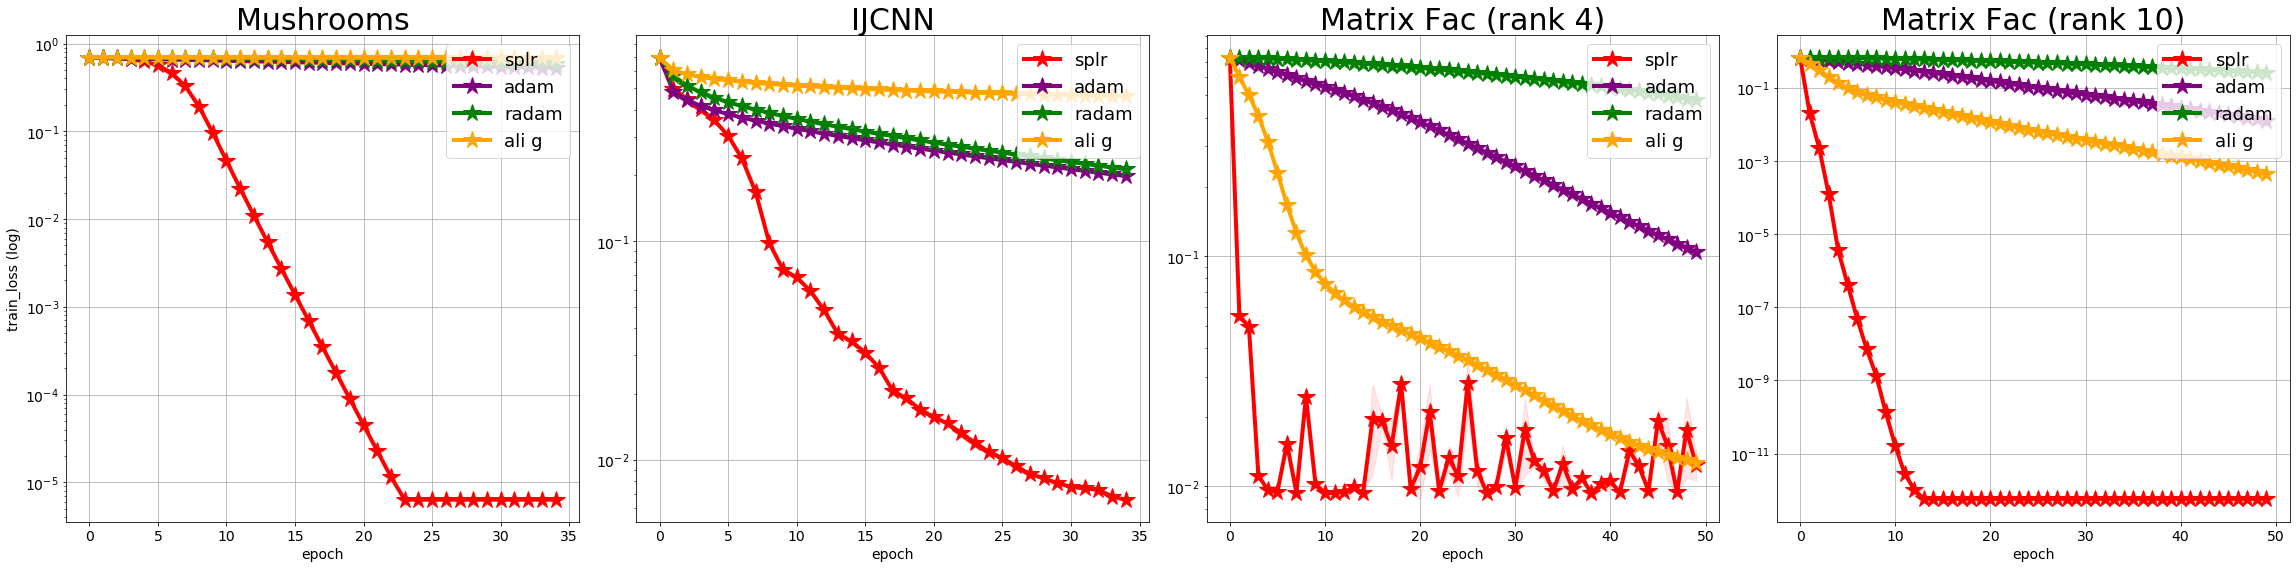

In [62]:
kernel_datasets = [{'dataset':d} for d in ["mushrooms", "ijcnn"]]
mf_datasets = [{'dataset':'matrix_fac', 'model':m} for m in ["matrix_fac_4", "matrix_fac_10"]]
# syn_datasets = [{'dataset':'synthetic', 'margin':m} for m in [0.1, 0.01, 0.05,  0.5]]

# print(kernel_datasets)
# stop
exp_group_list = rm.get_exp_sublists( 
                            regard_dict_list=[
                                (kernel_datasets +  mf_datasets),
                                [
                                {'opt':{'name':'splr',  'c':0.5, 'adapt_flag':'smooth_iter'}},
#                                 {'opt':{'name':'sgd_armijo', 'c':0.1, 'gamma':1.5}, 'max_epoch':50},
#                                  {'opt':{'name':'sgd_armijo', 'c':0.1, 'gamma':1.5}, 'max_epoch':35},
                                {'opt':{'name':'radam'}},
                                {'opt':{'name':'adam'}},
#                                 {'opt':{'name':'lookahead'}},
                                {'opt':{'name':'ali_g', 'momentum':0, 'max_lr':0.1}}
#                                 {'opt':{'name':'splr', 'adapt_flag':'constant', 'c':0.5}},
#                                         {'opt':{'name':'splr', 'adapt_flag':'smooth_iter', 'c':0.05}},
#                                 {'opt':{'name':'splr', 'adapt_flag':'smooth_iter', 'c':0.1}},
#                                 {'opt':{'name':'splr', 'adapt_flag':'smooth_iter', 'c':0.25}},
#                                          {'opt':{'name':'sgd_armijo','c':0.1}}
                            ]],
                            groupby_list = ['dataset', 'model'],
                            order_groups=['mushrooms_linear', 'ijcnn_linear', 
                                              'matrix_fac_matrix_fac_4', 
                                              'matrix_fac_matrix_fac_10']
                                   ) 




    
fig = hr.plot_exp_group_list(exp_group_list, y_list=['train_loss'], savedir_base=savedir_base, 
    title_list=['dataset', 'model'],
    title_dict={'mushrooms_linear':'Mushrooms',
               'ijcnn_linear': 'IJCNN',
               'matrix_fac_matrix_fac_4':'Matrix Fac (rank 4)',
               'matrix_fac_matrix_fac_10':'Matrix Fac (rank 10)'},
    avg_runs=1,
    legend_list=['opt'],
    height=8,
    width=8,
    color_regard_dict=color_regard_dict,
    label_regard_dict=label_regard_dict,
    legend_fontsize=18,
                          x_fontsize=14,
                          y_fontsize=14,
                          xtick_fontsize=14,
                          ytick_fontsize=14,
                          title_fontsize=30,
                          linewidth=4,
                          markersize=18,
                          y_only_first_flag=True,
                             bar_flag=None,
                          legend_kwargs={'loc':'upper right'}
#     label_regard_dict={}
#     xlim_list=[(1,10), None,(20, 30),None],
    )
    # plt.savefig('%s/results/%s_%d.jpg' % (workdir, exp_group_name, i))
plt.show()

[{'dataset': 'cifar10', 'model': 'resnet34', 'loss_func': 'softmax_loss', 'opt': {'name': 'splr', 'c': 0.1, 'adapt_flag': 'smooth_iter'}, 'acc_func': 'softmax_accuracy', 'batch_size': 128, 'max_epoch': 200, 'runs': 0}, {'dataset': 'cifar10', 'model': 'resnet34', 'loss_func': 'softmax_loss', 'opt': {'name': 'splr', 'c': 0.1, 'adapt_flag': 'smooth_iter'}, 'acc_func': 'softmax_accuracy', 'batch_size': 128, 'max_epoch': 200, 'runs': 1}, {'dataset': 'cifar10', 'model': 'resnet34', 'loss_func': 'softmax_loss', 'opt': {'name': 'splr', 'c': 0.1, 'adapt_flag': 'smooth_iter'}, 'acc_func': 'softmax_accuracy', 'batch_size': 128, 'max_epoch': 200, 'runs': 2}, {'dataset': 'cifar10', 'model': 'resnet34', 'loss_func': 'softmax_loss', 'opt': {'name': 'splr', 'c': 0.1, 'adapt_flag': 'smooth_iter'}, 'acc_func': 'softmax_accuracy', 'batch_size': 128, 'max_epoch': 200, 'runs': 3}, {'dataset': 'cifar10', 'model': 'resnet34', 'loss_func': 'softmax_loss', 'opt': {'name': 'splr', 'c': 0.1, 'adapt_flag': 'smoot

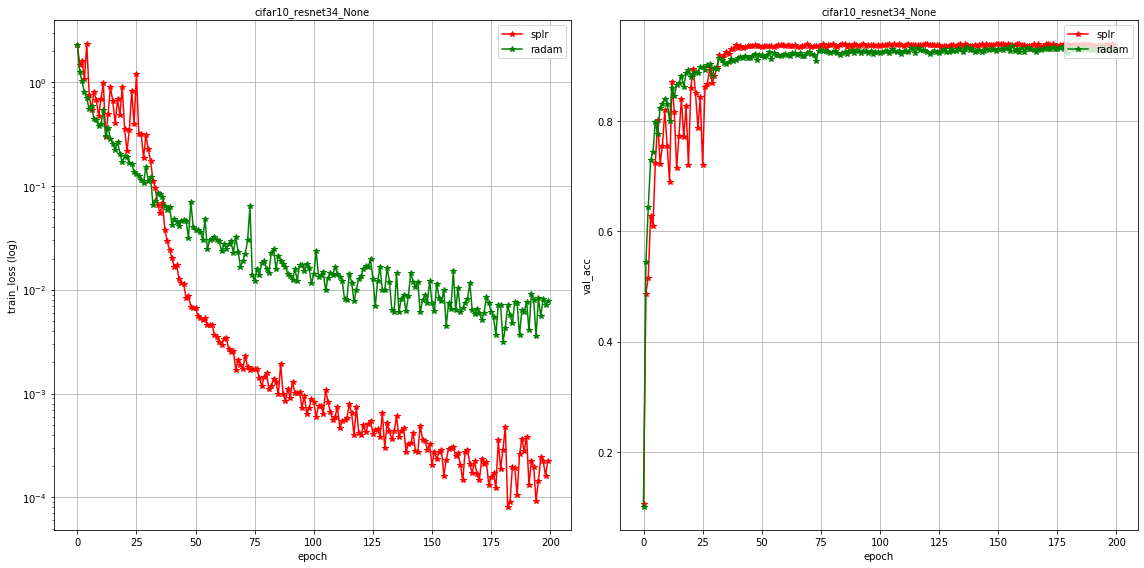

In [26]:
# plot across metrics
exp_list = []
for exp_group_name in ['splr_inter']:
    exp_list += EXP_GROUPS[exp_group_name]

deep_datasets = [                 
                 {'dataset':'cifar10', 'model':'resnet34'}, 
]

# stop
exp_group_list = hr.filter_exp_list(exp_list, 
                            regard_dict=[[{'dataset':'cifar10', 'model':'resnet34'}, ],
                                [{'opt':{'name':'splr',  'c':0.1, 'adapt_flag':'smooth_iter'}},
                                {'opt':{'name':'radam'}},]
                            ],
                            disregard_dict=None) 




for i, exp_group in enumerate(exp_group_list):
    # exp_subset = hr.filter_best_results(exp_subset, savedir_base=savedir_base, groupby_key_list=['model'], score_key='val_mae')
    
    # score df
#     df = hr.get_dataframe_score_list(exp_subset, savedir_base=savedir_base)
#     display(df)
    print(exp_group)
    # plot
    fig = hr.plot_exp_group_list([exp_group], y_list=['train_loss', 'val_acc'], savedir_base=savedir_base, 
    title_list=['dataset', 'model', 'margin'],
    avg_runs=1,
    legend_list=['opt'],
    height=8,
    width=8,
     color_regard_dict=color_regard_dict,
    label_regard_dict=label_regard_dict,
                              legend_kwargs={'loc':'upper right'}
    )
    # plt.savefig('%s/results/%s_%d.jpg' % (workdir, exp_group_name, i))
    plt.show()

    # qualitative
#     hr.get_images(exp_subset, savedir_base, n_exps=3, split="row",
#                   height=12,
#                   width=12, legend_list=['opt'])
          

NameError: name 'exp_group_list' is not defined

In [23]:
# show qualitative results
hr.get_images(exp_group, savedir_base, n_exps=3, split="row",
              height=12,
              width=12, legend_list=['opt'])

Exp: 7e2cf6cc56904aada1e552327f19b8ba
no images in /mnt/datasets/public/issam/prototypes/sls/borgy//7e2cf6cc56904aada1e552327f19b8ba/
Exp: 54216cd3be13fe4da39b420f6d0f33ec
no images in /mnt/datasets/public/issam/prototypes/sls/borgy//54216cd3be13fe4da39b420f6d0f33ec/
Exp: 897bca5f068eb7ebf27bb4c26be6afd7
no images in /mnt/datasets/public/issam/prototypes/sls/borgy//897bca5f068eb7ebf27bb4c26be6afd7/


In [24]:
# show dataframe
exp_list = get_exp_list()
kernel_datasets = [{'dataset':d} for d in ["mushrooms", "ijcnn"]]
mf_datasets = [{'dataset':'matrix_fac', 'model':m} for m in ["matrix_fac_4", "matrix_fac_10"]]
# syn_datasets = [{'dataset':'synthetic', 'margin':m} for m in [0.1, 0.01, 0.05,  0.5]]

exp_group_list = hr.filter_exp_list(exp_list, 
                                    regard_dict=kernel_datasets +  mf_datasets,
                                    disregard_dict=None) 

df = hr.get_dataframe_score_list(exp_group_list, savedir_base=savedir_base)
display(df)

,dataset,model,loss_func,acc_func,opt,batch_size,max_epoch,runs,epoch,train_loss,val_acc,step_size,n_forwards,n_backwards,grad_norm,train_epoch_time
exp_id,,,,,,,,,,,,,,,,
7eebe5b9befe91d72790d7ff22273e5c,mushrooms,linear,logistic_loss,logistic_accuracy,"{'name': 'splr', 'c': 0.15, 'adapt_flag': 'con...",100.0,35.0,0.0,34.0,0.022 (0.022-0.693),1.000 (0.484-1.000),100,2240,2240,0.002 (0.002-0.046),0.210 (0.192-0.229)
a19b2bd3b59ba8a67660e23ba8a9ee34,mushrooms,linear,logistic_loss,logistic_accuracy,"{'name': 'splr', 'c': 0.15, 'adapt_flag': 'con...",100.0,35.0,1.0,34.0,0.022 (0.022-0.693),1.000 (0.484-1.000),100,2240,2240,0.002 (0.002-0.046),0.210 (0.166-0.305)
33ce9c49d5d8416b896775e37a12dbe6,mushrooms,linear,logistic_loss,logistic_accuracy,"{'name': 'splr', 'c': 0.15, 'adapt_flag': 'con...",100.0,35.0,2.0,34.0,0.022 (0.022-0.693),1.000 (0.484-1.000),100,2240,2240,0.002 (0.002-0.046),0.242 (0.200-0.309)
5aca80502adab916887381e8b8b33bc8,mushrooms,linear,logistic_loss,logistic_accuracy,"{'name': 'splr', 'c': 0.15, 'adapt_flag': 'con...",100.0,35.0,3.0,34.0,0.022 (0.022-0.693),1.000 (0.484-1.000),100,2240,2240,0.002 (0.002-0.046),0.201 (0.172-0.254)
1aecd9374702ba3fd117af83abf00c13,mushrooms,linear,logistic_loss,logistic_accuracy,"{'name': 'splr', 'c': 0.15, 'adapt_flag': 'con...",100.0,35.0,4.0,34.0,0.022 (0.022-0.693),1.000 (0.484-1.000),100,2240,2240,0.002 (0.002-0.046),0.211 (0.191-0.247)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85b389b4dd9661787f0e58bb0b2564de,matrix_fac,matrix_fac_10,squared_loss,mse,"{'name': 'ali_g', 'momentum': 0.0, 'max_lr': 0.1}",100.0,50.0,0.0,49.0,0.000 (0.000-0.673),0.000 (0.000-0.788),0.100 (0.100-0.100),{},{},{},0.018 (0.017-0.025)
4eb95e9d4f10f7ccb9b8f9e8553a9b14,matrix_fac,matrix_fac_10,squared_loss,mse,"{'name': 'ali_g', 'momentum': 0.0, 'max_lr': 0.1}",100.0,50.0,1.0,49.0,0.000 (0.000-0.673),0.000 (0.000-0.788),0.100 (0.100-0.100),{},{},{},0.035 (0.015-0.037)
bda8aa3a22776967f8a120d18771734c,matrix_fac,matrix_fac_10,squared_loss,mse,"{'name': 'ali_g', 'momentum': 0.0, 'max_lr': 0.1}",100.0,50.0,2.0,49.0,0.000 (0.000-0.673),0.000 (0.000-0.788),0.100 (0.100-0.100),{},{},{},0.015 (0.014-0.033)


In [ ]:
# zip files

In [3]:
# send zip to dropbox